# 1- Importer les bibliothèques

# Analyse de la consommation énergétique dans l'industrie sidérurgique

---

## 1. Import des bibliothèques et lecture des données
Nous importons les bibliothèques nécessaires et lisons le fichier CSV pour obtenir un aperçu des données.

---

## 2. Inspection initiale des données
On vérifie la forme du dataset, les types de données, les valeurs manquantes et les statistiques descriptives pour comprendre la structure des données.

---

## 3. Nettoyage et conversion des types
- Conversion de la colonne `Date_Time` en type datetime.
- Conversion des colonnes numériques pour s'assurer qu'elles sont exploitables.

---

## 4. Index temporel et tri
- Tri des données par date.
- Définition de `Date_Time` comme index pour faciliter l'analyse temporelle.

---

## 5. Visualisation de la consommation dans le temps
- Tracé de la consommation (`Usage_kWh`) sur la série temporelle complète pour observer les tendances.

---

## 6. Statistiques journalières et hebdomadaires
- Résumé de la consommation par jour et par semaine pour détecter les patterns et variations.

---

## 7. Corrélations entre variables
- Création d'une heatmap pour visualiser les relations entre les colonnes numériques et identifier les dépendances.

---

## 8. Feature Engineering
- Création de nouvelles variables temporelles : heure, jour, mois, jour de la semaine, week-end.
- Création de lags et moyennes glissantes pour capturer les tendances passées.

---

## 9. Split train/test
- Séparation temporelle des données pour entraîner les modèles et tester leurs performances tout en évitant le data leakage.

---

## 10. Baseline
- Utilisation d'une prédiction simple (consommation 24h précédente) comme référence pour comparer les modèles plus sophistiqués.

---

## 11. Modèle LightGBM
- Application d'un modèle de gradient boosting pour prédire la consommation horaire.
- Evaluation des performances avec MAE et RMSE.

---

## 12. Modèle Prophet
- Modélisation des tendances et des saisonnalités quotidiennes et hebdomadaires avec Prophet.
- Génération de prédictions et évaluation sur le set de test.

---

## 13. Détection d’anomalies
- Utilisation d'Isolation Forest pour détecter des consommations inhabituelles ou des pics anormaux.
- Identification des anomalies qui peuvent correspondre à des inefficacités ou défaillances d'équipements.

---

## 14. Visualisation des anomalies
- Affichage des anomalies détectées sur la série temporelle pour les repérer facilement.


# 1- Importation des bibliothèques

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta



# 2- Charger Data

In [4]:
data = pd.read_csv('/kaggle/input/steel-industry-datasets/Steel_industry.csv', skipinitialspace=True)
data.head()

,Date_Time,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_Of_Week,Load_Type
0,01-01-2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01-01-2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01-01-2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01-01-2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01-01-2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


# 3- Inspection initiale

In [5]:
data.shape

(35041, 11)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35041 entries, 0 to 35040
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date_Time                             35041 non-null  object 
 1   Usage_kWh                             35041 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35041 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35041 non-null  float64
 4   CO2(tCO2)                             35041 non-null  float64
 5   Lagging_Current_Power_Factor          35041 non-null  float64
 6   Leading_Current_Power_Factor          35041 non-null  float64
 7   NSM                                   35041 non-null  int64  
 8   WeekStatus                            35041 non-null  object 
 9   Day_Of_Week                           35041 non-null  object 
 10  Load_Type                             35041 non-null  object 
dtypes: float64(6), 

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Usage_kWh,35041.0,27.386229,33.444133,0.0,3.20,4.57,51.23,157.18
Lagging_Current_Reactive.Power_kVarh,35041.0,13.035012,16.305916,0.0,2.30,5.00,22.64,96.91
Leading_Current_Reactive_Power_kVarh,35041.0,3.871412,7.424863,0.0,0.00,0.00,2.09,27.76
CO2(tCO2),35041.0,0.011524,0.016151,0.0,0.00,0.00,0.02,0.07
Lagging_Current_Power_Factor,35041.0,80.578610,18.921337,0.0,63.32,87.96,99.03,100.00
Leading_Current_Power_Factor,35041.0,84.366038,30.458030,0.0,99.70,100.00,100.00,100.00
NSM,35041.0,42750.834736,24940.667915,0.0,21600.00,43200.00,64800.00,85500.00


In [8]:
data.mode()

,Date_Time,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_Of_Week,Load_Type
0,31-12-2018 20:00,3.06,0.0,0.0,0.0,100.0,100.0,72000,Weekday,Monday,Light_Load


In [9]:
data["Usage_kWh"].unique()

array([ 3.17,  4.  ,  3.24, ..., 17.82, 45.  ,  4.15])

# 4- Analyse Exploratoire (EDA)

In [10]:
data.columns

Index(['Date_Time', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_Of_Week', 'Load_Type'],
      dtype='object')

In [11]:
# valeurs manquantes
missing = data.isnull().sum().sort_values(ascending=False)
print(missing[missing>0])


Series([], dtype: int64)


## Pairplot

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

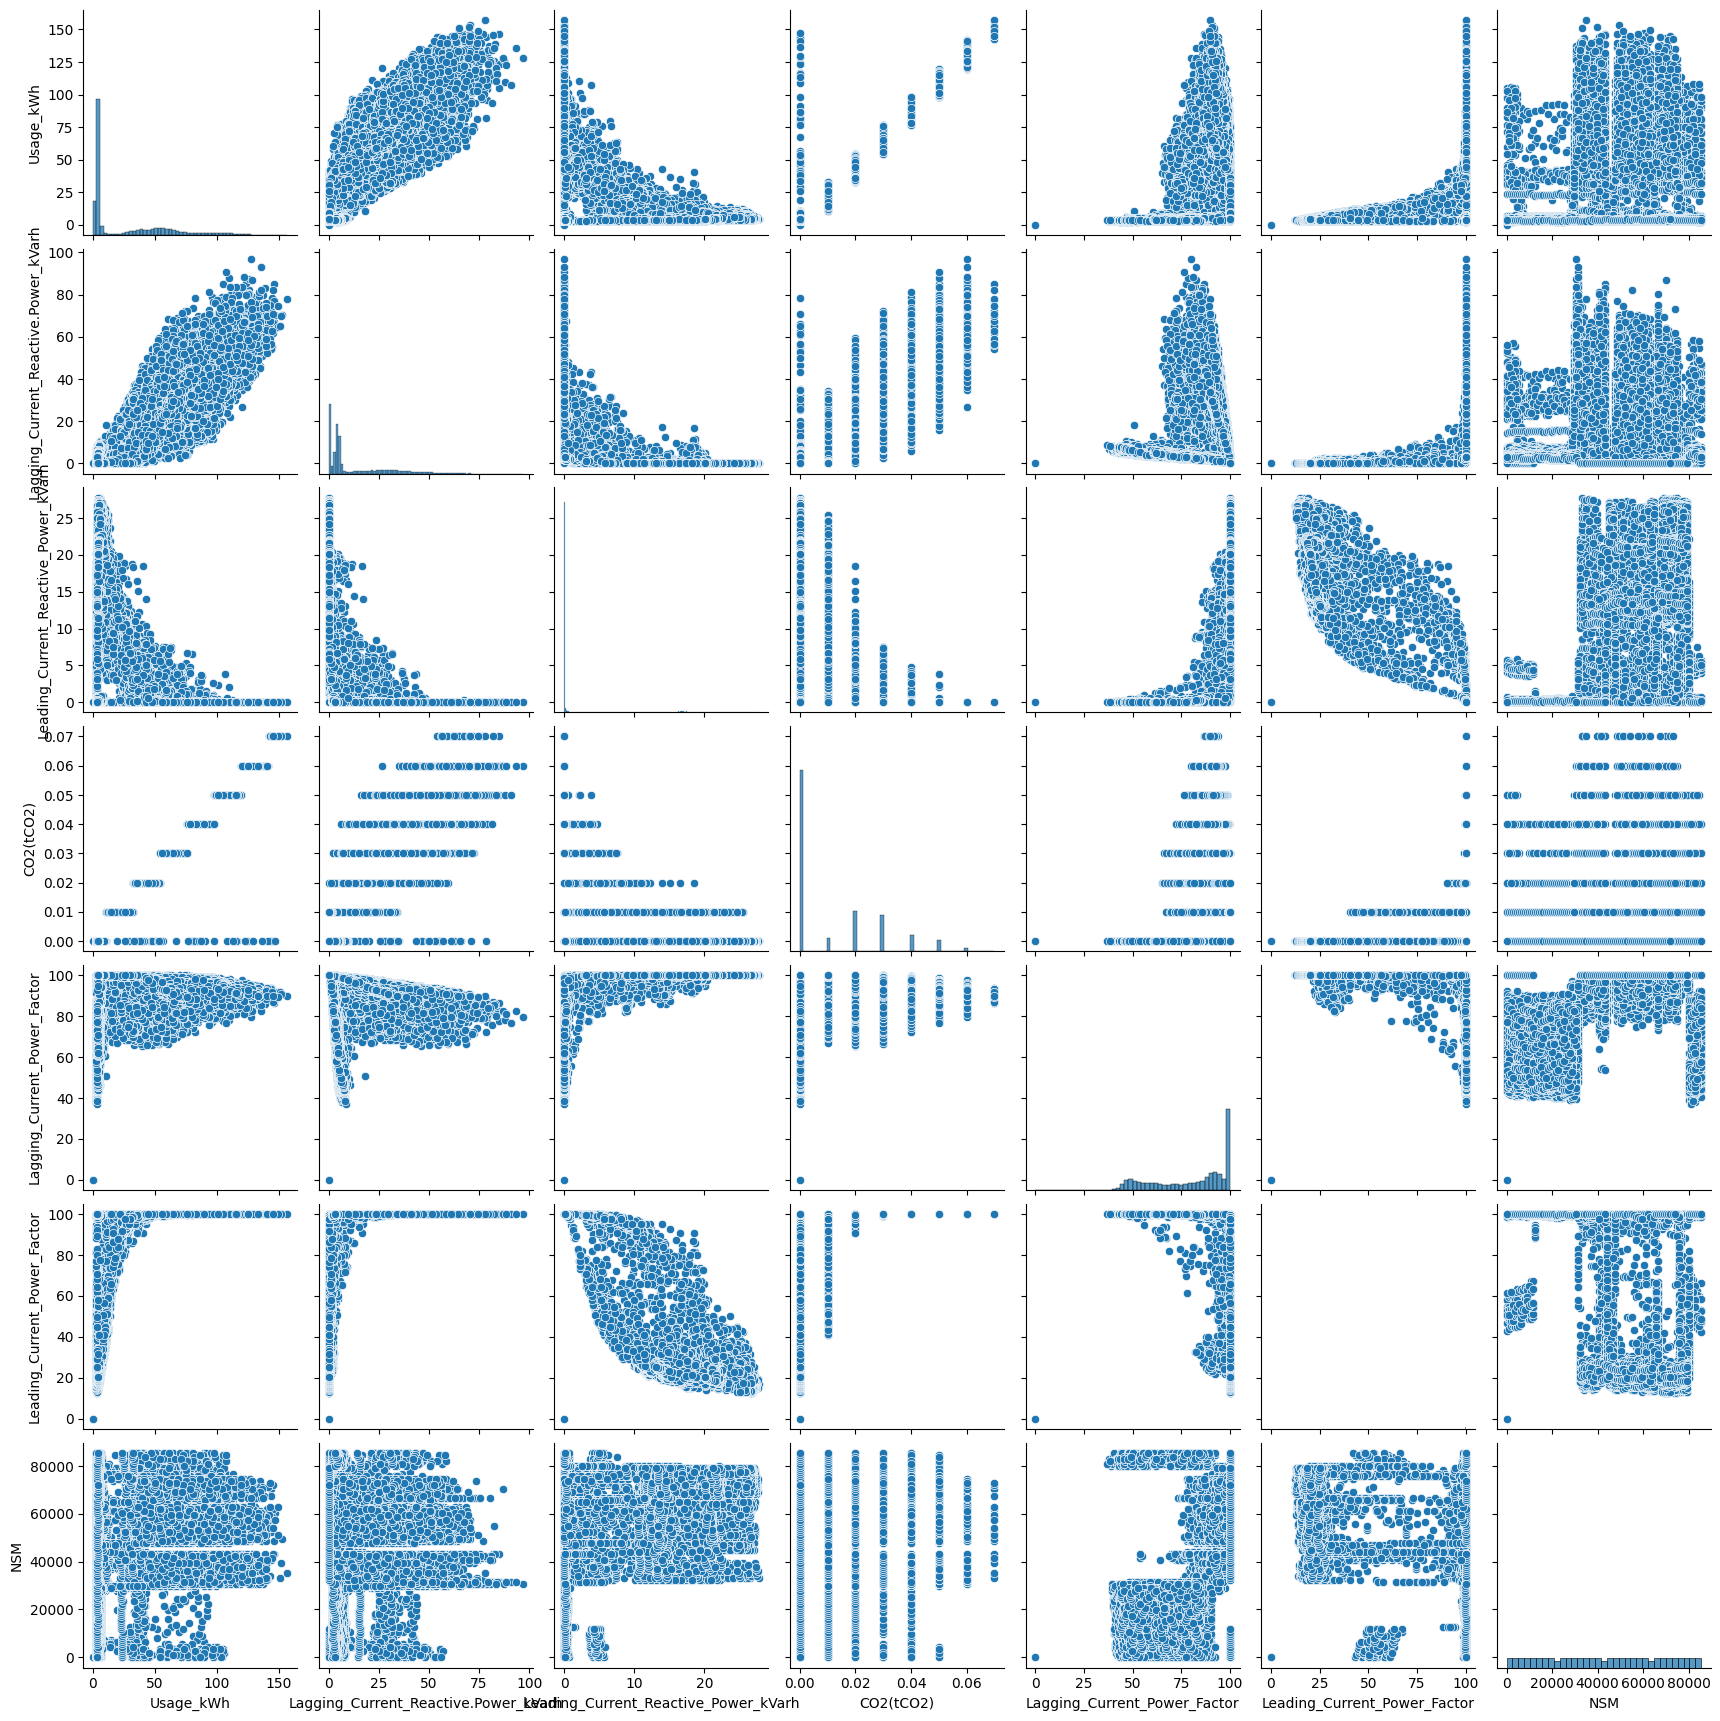

In [12]:
import seaborn as sns
sns.pairplot(data)

## la boîte à moustaches de la consommation énergétique (Usage_kWh)

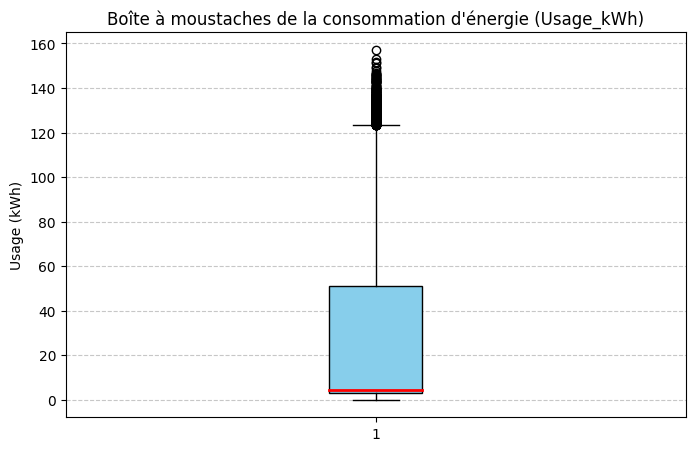

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

plt.boxplot(
    data['Usage_kWh'].dropna(),
    patch_artist=True,
    boxprops=dict(facecolor='skyblue'),
    medianprops=dict(color='red', linewidth=2)
)

plt.title("Boîte à moustaches de la consommation d'énergie (Usage_kWh)")
plt.ylabel("Usage (kWh)")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


#  heatmap des Corrélations

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(0.5, 1.0, 'Corrélation entre variables')

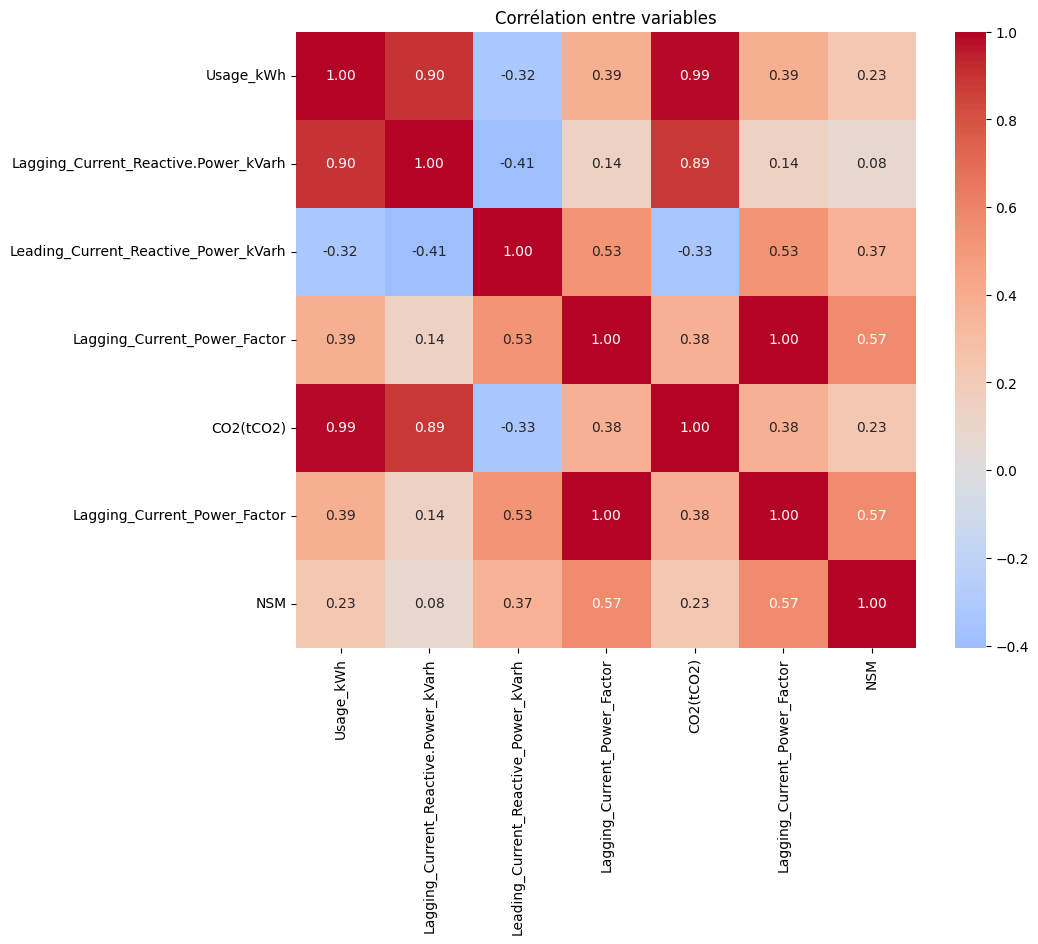

In [14]:
num_cols = ['Usage_kWh',"Lagging_Current_Reactive.Power_kVarh","Leading_Current_Reactive_Power_kVarh","Lagging_Current_Power_Factor",
           "CO2(tCO2)","Lagging_Current_Power_Factor","NSM"]
plt.figure(figsize=(10,8))
corr = data[num_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Corrélation entre variables')


# 5- Nettoyage et conversion des types

In [15]:
data['Date_Time'] = pd.to_datetime(data['Date_Time'], format='%d-%m-%Y %H:%M', errors='coerce')
# tri temporel
data = data.sort_values('Date_Time').set_index('Date_Time')

# 6- Visualisation de la consommation dans le temps

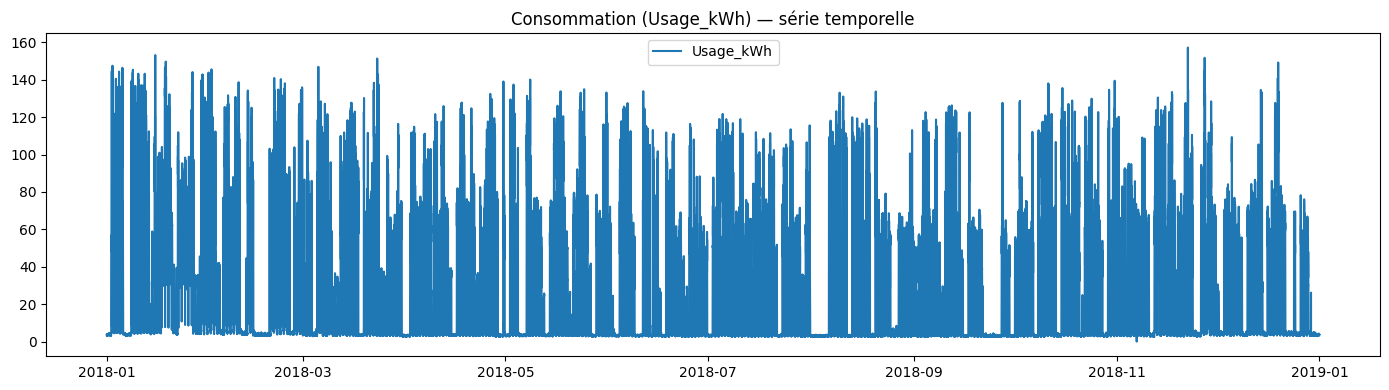

In [16]:
plt.figure(figsize=(14,4))
plt.plot(data.index, data['Usage_kWh'], label='Usage_kWh')
plt.title('Consommation (Usage_kWh) — série temporelle')
plt.legend()
plt.tight_layout()


# 7- Statistiques par jour / semaine

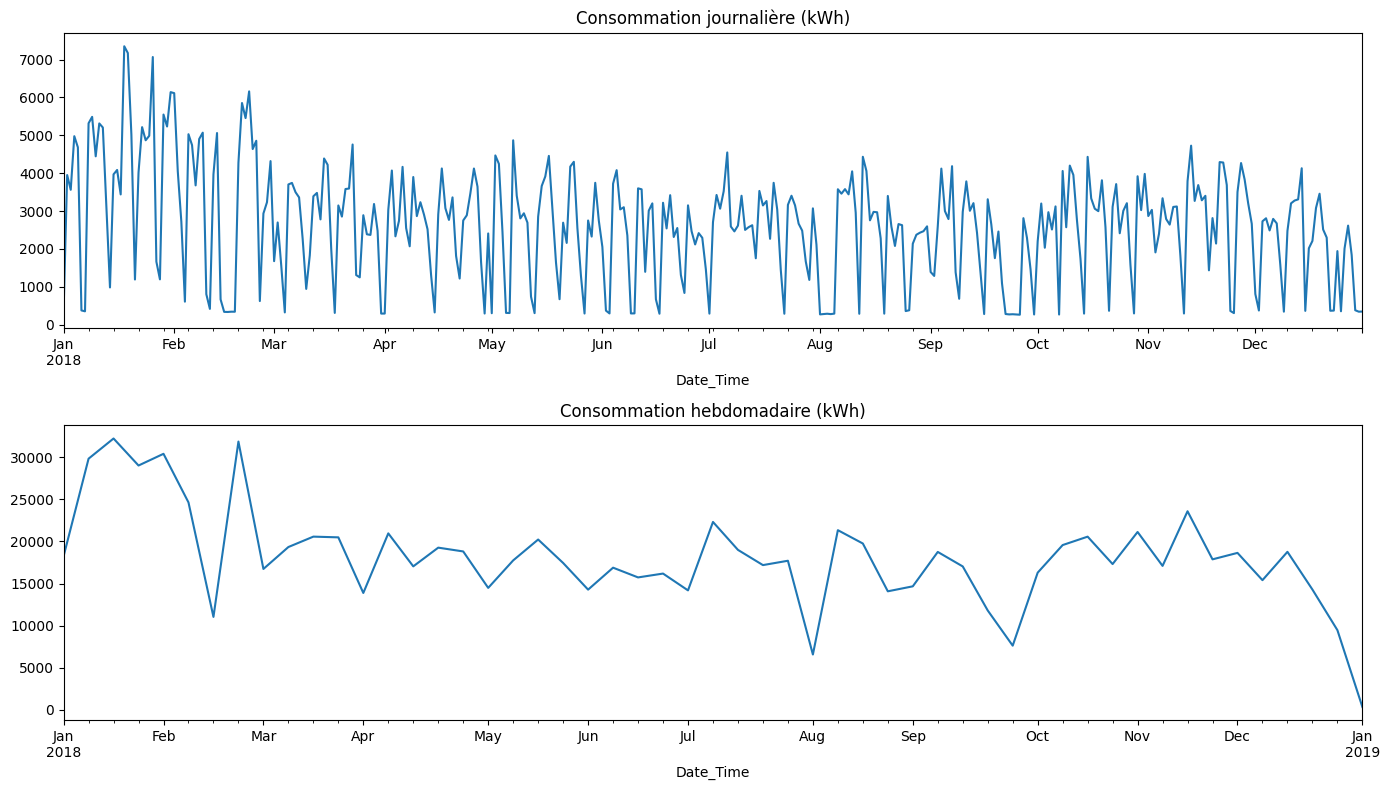

In [17]:
# resample journalier
daily = data['Usage_kWh'].resample('D').sum()
weekly = data['Usage_kWh'].resample('W').sum()

# plot
fig, ax = plt.subplots(2,1,figsize=(14,8))
daily.plot(ax=ax[0], title='Consommation journalière (kWh)')
weekly.plot(ax=ax[1], title='Consommation hebdomadaire (kWh)')
plt.tight_layout()


# 8-Feature engineering (essentiel pour modèles)

In [26]:
df = data.copy()

# features temporelles
df['hour'] = df.index.hour
df['day'] = df.index.day
df['weekday'] = df.index.weekday  # 0=Mon
df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
df['month'] = df.index.month

# lags et rolling
df['lag_1h'] = df['Usage_kWh'].shift(1)
df['lag_24h'] = df['Usage_kWh'].shift(24*4)
df['rolling_24h_mean'] = df['Usage_kWh'].rolling(window=24*4, min_periods=1).mean()

# drop NaN créés par shift
df = df.dropna(subset=['lag_1h','lag_24h'])


# 9- Train / test split temporel

In [27]:
# fraction temporelle, e.g. 80% train
split_date = df.index[int(len(df)*0.8)]
train = df.loc[:split_date]
test = df.loc[split_date + pd.Timedelta(seconds=1):]

print("train:", train.shape, "test:", test.shape)


train: (27957, 18) test: (6988, 18)


# 10- Baseline (persistence)  métriques

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# baseline: prédire la valeur 24h avant
y_true = test['Usage_kWh']
y_pred_baseline = test['lag_24h']  
print("MAE baseline:", mean_absolute_error(y_true, y_pred_baseline))
print("RMSE baseline:", mean_squared_error(y_true, y_pred_baseline, squared=False))


MAE baseline: 15.073955352032053
RMSE baseline: 27.642526669629312


# 11- Modèle LightGBM (tree-based) supervisé

In [29]:
import lightgbm as lgb

features = ['lag_1h','lag_24h','rolling_24h_mean','hour','weekday','is_weekend','month',
            'Usage_kWh',"Lagging_Current_Reactive.Power_kVarh","Leading_Current_Reactive_Power_kVarh","Leading_Current_Power_Factor",
           "CO2(tCO2)","Lagging_Current_Power_Factor","NSM"]

X_train = train[features]
y_train = train['Usage_kWh']
X_test = test[features]
y_test = test['Usage_kWh']

dtrain = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt'
}
model = lgb.train(params, dtrain, num_boost_round=100)
y_pred = model.predict(X_test)

print("MAE LGBM:", mean_absolute_error(y_test, y_pred))
print("RMSE LGBM:", mean_squared_error(y_test, y_pred, squared=False))


MAE LGBM: 0.0796020710164219
RMSE LGBM: 0.22896914123029896


# 12- Série temporelle avec Prophet (supervisé)

                                     ds     y
Date_Time                                    
2018-01-01 00:00:00 2018-01-01 00:00:00  3.42
2018-01-01 00:15:00 2018-01-01 00:15:00  3.17
2018-01-01 00:30:00 2018-01-01 00:30:00  4.00
2018-01-01 00:45:00 2018-01-01 00:45:00  3.24
2018-01-01 01:00:00 2018-01-01 01:00:00  3.31


21:07:49 - cmdstanpy - INFO - Chain [1] start processing
21:08:02 - cmdstanpy - INFO - Chain [1] done processing


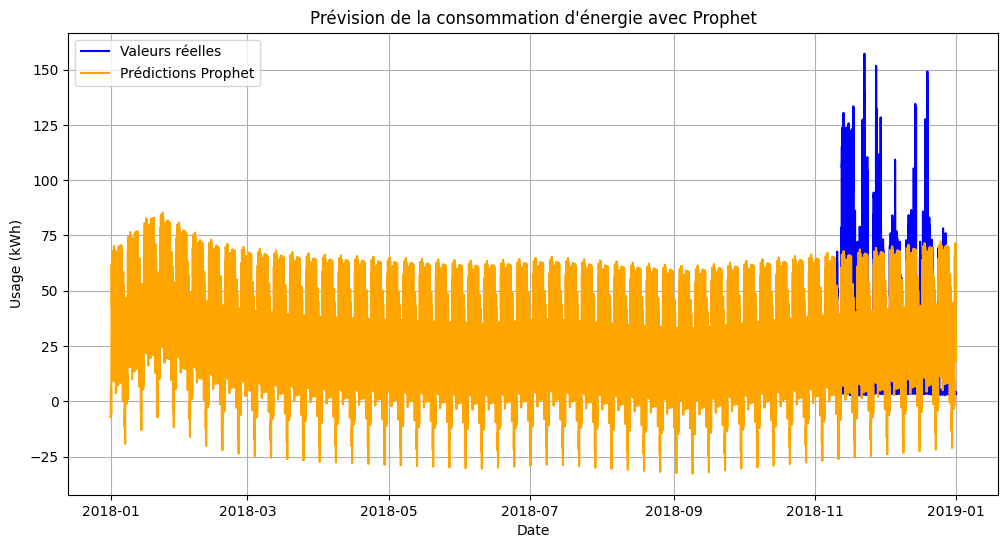

MAE Prophet : 18.394
RMSE Prophet : 23.898


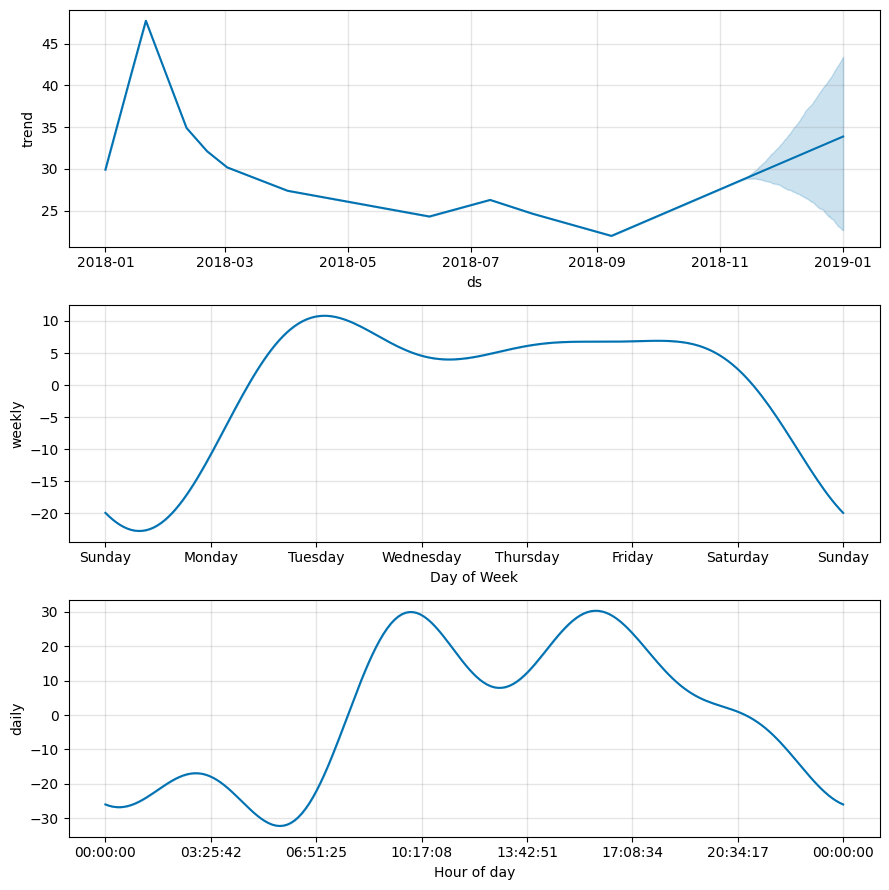

In [30]:
from prophet import Prophet


# Préparation des données
df_prophet = data.copy()

# Prophet attend les colonnes "ds" (date) et "y" (valeur à prédire)
df_prophet = df_prophet.rename(columns={"Usage_kWh": "y"})
df_prophet["ds"] = df_prophet.index  # L'index devient la colonne 'ds'
df_prophet = df_prophet[["ds", "y"]]  # Garder seulement ce qui est utile

# Vérification rapide
print(df_prophet.head())


# on garde les 5000 dernières valeurs pour le test
train = df_prophet.iloc[:-5000]
test = df_prophet.iloc[-5000:]

#  Création et entraînement du modèle Prophet
model = Prophet(
    daily_seasonality=True,    # Capture les variations journalières
    weekly_seasonality=True,   # Capture les cycles hebdomadaires
    yearly_seasonality=False,  # Pas besoin de saisonnalité annuelle
)
model.fit(train)

#Prédiction sur les données futures
future = model.make_future_dataframe(periods=len(test), freq='15min')  
forecast = model.predict(future)

# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(test["ds"], test["y"], label="Valeurs réelles", color="blue")
plt.plot(forecast["ds"], forecast["yhat"], label="Prédictions Prophet", color="orange")
plt.legend()
plt.title("Prévision de la consommation d'énergie avec Prophet")
plt.xlabel("Date")
plt.ylabel("Usage (kWh)")
plt.grid(True)
plt.show()

# Évaluation du modèle
y_true = test["y"].values
y_pred = forecast["yhat"].iloc[-len(test):].values

mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)

print(f"MAE Prophet : {mae:.3f}")
print(f"RMSE Prophet : {rmse:.3f}")

# Décomposition des tendances et saisonnalités

model.plot_components(forecast)
plt.show()


# 13- Détection d’anomalies : Isolation Forest (non supervisé)

In [31]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.01, random_state=42)
# features simples
anom_features = ['Usage_kWh','lag_1h','lag_24h']
anom_features = [f for f in anom_features if f in df.columns]
iso.fit(df[anom_features])
df['anomaly'] = iso.predict(df[anom_features])  # -1 anomaly, 1 normal
anoms = df[df['anomaly']==-1]
print("anomalies détectées:", anoms.shape[0])


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


anomalies détectées: 350


# 14- Visualisation anomalies

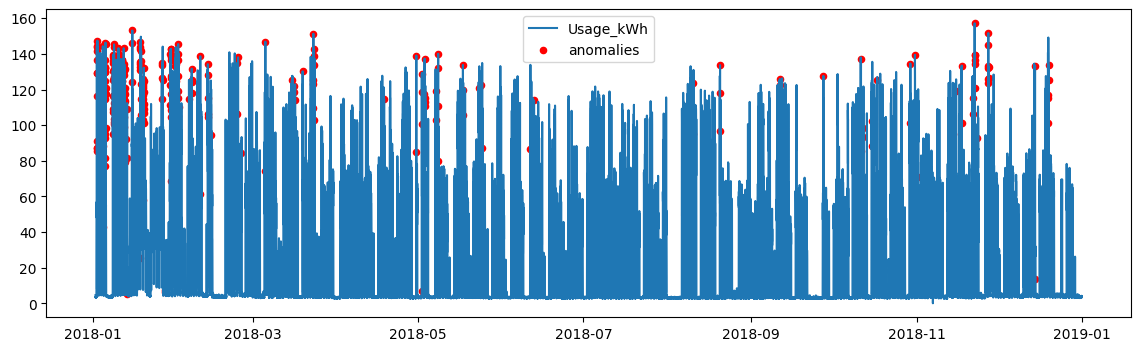

In [32]:
plt.figure(figsize=(14,4))
plt.plot(df.index, df['Usage_kWh'], label='Usage_kWh')
plt.scatter(anoms.index, anoms['Usage_kWh'], color='red', s=20, label='anomalies')
plt.legend()
